In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from utils import resample_ohlcv, calculate_returns
import pandas_market_calendars as mcal
import os
from preprocessing import map_expiries_to_dates
import warnings
pd.set_option('display.max_rows', 200)
# Suppress specific warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [93]:
resampling_freq = None
# resampling_freq = '1D'

In [94]:
col_dict = {'open_price_col': 'open', 'high_price_col': 'high', 'low_price_col': 'low', 'close_price_col': 'close', 'volume_col': 'volume', 
            'time_col':'datetime', 'expiry_col':'expiry_date', 'expiry_type_col':'expiry_type',
            'oi_col':'open_interest','date_col':'date','div_yield_col':'Div Yield %',
            'rfr_col':'MIBOR'}

In [67]:
data = pd.read_csv('Data/Nifty_Futures_01Jan2020_29Jan25.csv',parse_dates=['datetime','expiry_date'])
data.head(3)

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_32900\214887548.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('Data/Nifty_Futures_01Jan2020_29Jan25.csv',parse_dates=['datetime','expiry_date'])


,datetime,stock_code,exchange_code,product_type,expiry_date,right,strike_price,open,high,low,close,volume,open_interest,count
0,2020-01-01 09:15:00,NIFTY,NFO,Futures,2020-01-30,Others,0,12253.9502,12266.75,12252.7002,12265.2998,107927,12263025,0
1,2020-01-01 09:16:00,NIFTY,NFO,Futures,2020-01-30,Others,0,12265.2998,12265.50,12256.4004,12256.5996,50250,12263025,1
2,2020-01-01 09:17:00,NIFTY,NFO,Futures,2020-01-30,Others,0,12256.9502,12257.00,12255.0000,12255.0000,48975,12250950,2


In [68]:
data['datetime'].max()

Timestamp('2025-01-29 15:29:00')

In [69]:
nifty = pd.read_csv('Data/Nifty_01Jan2020_29Jan2025.csv',parse_dates=['datetime'])
print(nifty.shape)
nifty.head()


(471828, 8)


,datetime,close,exchange_code,high,low,open,stock_code,volume
0,2020-01-01 09:07:00,12202.15,NSE,12202.15,12202.15,12202.15,NIFTY,0
1,2020-01-01 09:15:00,12215.45,NSE,12216.25,12201.55,12201.55,NIFTY,0
2,2020-01-01 09:16:00,12206.50,NSE,12216.45,12205.70,12214.55,NIFTY,0
3,2020-01-01 09:17:00,12203.55,NSE,12207.40,12202.70,12205.85,NIFTY,0
4,2020-01-01 09:18:00,12208.35,NSE,12208.40,12201.20,12202.15,NIFTY,0


In [70]:
## Cleansing nifty data

print(nifty.shape)
nifty.drop_duplicates(inplace=True)
print(nifty.shape)
nifty = nifty.groupby(col_dict['time_col'],as_index=False).first()
print(nifty.shape)

(471828, 8)
(471828, 8)
(471828, 8)


In [71]:
## Cleansing nifty futures data
def cleanse_nifty_futures(df):
    # print(data.shape)
    df = df.drop(columns = 'count')
    df = df.drop_duplicates()
    # print(data.shape)
    duplicate_handling_df = df.groupby(col_dict['time_col'], as_index=False).agg(zero_oi = (col_dict['oi_col'],lambda x: (x==0).sum()), 
                                        num_expiries = (col_dict['expiry_col'],'count'))
    df = df.merge(duplicate_handling_df, on = col_dict['time_col'], how = 'left')

    # drop rows with multiple entries for the same expiry and having zero oi
    filt_data = df.loc[~(df['num_expiries']>3) | ~(df['zero_oi']>0) | ~(df[col_dict['oi_col']]==0)].copy(deep=True)

    # take the first occurence of the rows with multiple entries for the same expiry but non zero oi
    filt_data = filt_data.groupby([col_dict['time_col'],col_dict['expiry_col']],as_index=False).first()
    
    return filt_data.drop(columns = ['zero_oi','num_expiries'])
print(data.shape)
data_cleansed = cleanse_nifty_futures(data)
print(data_cleansed.shape)

(1351366, 14)
(1327337, 13)


In [72]:
data_cleansed[col_dict['time_col']].value_counts().value_counts()

count
3    388480
2     78931
1      4035
Name: count, dtype: int64

In [73]:
dividend = pd.read_csv('Data/DIV_Data_Jan2020toJan2025.csv',parse_dates=['Date']).rename(columns={'Date':col_dict['date_col']})
dividend.head(3)

,IndexName,date,P/E,P/B,Div Yield %
0,NIFTY 50,2025-02-01,21.29,3.50,1.38
1,NIFTY 50,2025-01-31,21.33,3.51,1.38
2,NIFTY 50,2025-01-30,21.12,3.47,1.37


In [74]:
rfr = pd.read_csv('Data/MIBOR_Jan2020toJan2025.csv',parse_dates=[col_dict['date_col']])
rfr.head()

,date,MIBOR
0,2020-01-01,5.75
1,2020-01-02,5.75
2,2020-01-03,5.74
3,2020-01-06,5.73
4,2020-01-07,5.73


In [75]:
from utils import continuous_compounder
rfr[col_dict['rfr_col']] = rfr[col_dict['rfr_col']].apply(lambda x: continuous_compounder(x/100))
dividend[col_dict['div_yield_col']] = dividend[col_dict['div_yield_col']].apply(lambda x: continuous_compounder(x/100))

In [76]:
dividend[col_dict['div_yield_col']].describe()

count    1267.000000
mean        0.012780
std         0.001495
min         0.009455
25%         0.011830
50%         0.012620
75%         0.013706
max         0.019803
Name: Div Yield %, dtype: float64

In [95]:
if resampling_freq:
    resampled_data = resample_ohlcv(data_cleansed, col_dict, groupby_col=[col_dict['expiry_col']], freq = resampling_freq).reset_index(drop=True)
    resampled_nifty = resample_ohlcv(nifty, col_dict,groupby_col=None, freq = resampling_freq).reset_index(drop=True)
else:
    resampled_data = data_cleansed.copy()
    resampled_nifty = nifty.copy()

In [96]:
resampled_data[col_dict['date_col']] = pd.to_datetime(resampled_data[col_dict['time_col']].dt.date)
resampled_nifty[col_dict['date_col']] = pd.to_datetime(resampled_nifty[col_dict['time_col']].dt.date)
# data[col_dict['expiry_type_col']] = data.groupby(col_dict['time_col'])[col_dict['expiry_col']].rank(method='first').replace({1: 'near', 2: 'mid', 3: 'far'})

In [97]:
working_days_df = mcal.get_calendar('NSE').schedule(data[col_dict['time_col']].min(),
                                                    pd.to_datetime(data[col_dict['time_col']].max())+pd.DateOffset(months = 6))
resampled_data.sort_values(col_dict['date_col'],inplace=True)
resampled_data.reset_index(inplace=True, drop = True)
resampled_data[col_dict['expiry_type_col']] = resampled_data.groupby(col_dict['date_col']).apply(lambda g : map_expiries_to_dates(g, list(working_days_df.index), col_dict)).values

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_32900\3722974103.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_data[col_dict['expiry_type_col']] = resampled_data.groupby(col_dict['date_col']).apply(lambda g : map_expiries_to_dates(g, list(working_days_df.index), col_dict)).values


In [98]:
resampled_data[col_dict['expiry_type_col']].value_counts()

expiry_type
near    471410
mid     464801
far     391126
Name: count, dtype: int64

In [99]:
resampled_data.shape, data.shape

((1327337, 15), (1351366, 14))

In [100]:
def merge_ohlc_with_rfr(ohlc_data, rfr_data, col_dict):
    """
    Merge minute frequency OHLC data with day-level risk-free rate (RFR) data.
    
    Parameters:
    ohlc_data (pd.DataFrame): DataFrame containing OHLC data with a 'timestamp' column.
    rfr_data (pd.DataFrame): DataFrame containing RFR data with a 'date' column.
    col_dict (dict): Dictionary containing column names for 'timestamp', 'date', and 'rfr'.
    
    Returns:
    pd.DataFrame: Merged DataFrame with OHLC data and corresponding RFR.
    """
    # Ensure the data is sorted by timestamp
    ohlc_data = ohlc_data.sort_values(by=col_dict['time_col'])
    rfr_data = rfr_data.sort_values(by=col_dict['date_col'])
    
    rfr_data[f"prev_{col_dict['rfr_col']}"] = rfr_data[col_dict['rfr_col']].shift(1)
    
    # Merge OHLC data with RFR data
    merged_data = pd.merge(ohlc_data, rfr_data, left_on=col_dict['date_col'], right_on=col_dict['date_col'], 
                           how='left', suffixes=('', '_rfr')
                           )
    ## MIBOR is available only after 10:45 AM, so we will use the previous day's MIBOR till 11:00 AM
    merged_data.loc[merged_data[col_dict['time_col']].dt.time < pd.Timestamp('11:00').time(), 
                    col_dict['rfr_col']] = merged_data[f"prev_{col_dict['rfr_col']}"]
   
    return merged_data

In [101]:
merged = merge_ohlc_with_rfr(resampled_data, rfr.dropna(), col_dict)
data.shape, merged.shape

((1351366, 14), (1327337, 17))

In [102]:
dividend.sort_values(col_dict['date_col'], inplace=True)
dividend.reset_index(drop=True, inplace=True)
merged = pd.merge(merged, dividend.set_index(col_dict['date_col']).shift(1).reset_index(), 
                  on=col_dict['date_col'], how='left')

In [85]:
resampled_data

,datetime,open,high,low,close,volume,open_interest,expiry_date,date,expiry_type
0,2020-01-01,12253.9502,12269.5996,12226.0498,12251.9004,4081502,1.249597e+07,2020-01-30,2020-01-01,near
1,2020-01-01,12302.2500,12309.8496,12270.0000,12291.5996,86252,9.645884e+05,2020-02-27,2020-01-01,mid
2,2020-01-01,12309.0498,12355.0498,12309.0498,12332.9004,18076,7.506359e+04,2020-03-26,2020-01-01,far
3,2020-01-02,12252.0996,12344.5000,12245.5000,12338.0000,6982953,1.263623e+07,2020-01-30,2020-01-02,near
4,2020-01-02,12299.4004,12386.0996,12298.2500,12376.0000,131252,9.723597e+05,2020-02-27,2020-01-02,mid
...,...,...,...,...,...,...,...,...,...,...
3759,2025-01-28,23217.5000,23421.0000,23141.5000,23260.0000,354450,6.396876e+05,2025-03-27,2025-01-28,far
3760,2025-01-28,23068.0000,23277.3000,22987.0000,23105.0000,5717475,9.028099e+06,2025-02-27,2025-01-28,mid
3761,2025-01-29,23013.3500,23180.9500,22970.9000,23176.9000,7186250,9.484300e+06,2025-01-30,2025-01-29,near
3762,2025-01-29,23168.6500,23319.1500,23103.0000,23310.7000,5361075,1.247252e+07,2025-02-27,2025-01-29,mid


In [103]:
near_month_data = merged.loc[merged[col_dict['expiry_type_col']] == 'near']
# near_month_data = calculate_theoretical_futures_price(near_month_data,
#                                                       [col_dict['open_price_col'], col_dict['close_price_col']], 
#                                                       col_dict)

mid_month_data = merged.loc[merged[col_dict['expiry_type_col']] == 'mid']
# mid_month_data = calculate_theoretical_futures_price(mid_month_data,
#                                                       [col_dict['open_price_col'], col_dict['close_price_col']], 
#                                                       col_dict)

far_month_data = merged.loc[merged[col_dict['expiry_type_col']] == 'far']
# far_month_data = calculate_theoretical_futures_price(far_month_data,
#                                                       [col_dict['open_price_col'], col_dict['close_price_col']], 
#                                                       col_dict)


req_cols = [col_dict['time_col'], col_dict['open_price_col'], col_dict['close_price_col'], col_dict['high_price_col'], col_dict['low_price_col'], 
            col_dict['volume_col'], col_dict['oi_col'], col_dict['expiry_col'],
            # f"{col_dict['open_price_col']}_theoretical", f"{col_dict['close_price_col']}_theoretical", 
            # f"{col_dict['open_price_col']}_price_diff", f"{col_dict['close_price_col']}_price_diff"
            ]
final_data1 = pd.merge(near_month_data, mid_month_data[req_cols], on=col_dict['time_col'], suffixes=('_near', '_mid'), how = 'left')
final_data = pd.merge(final_data1, far_month_data[req_cols].rename(columns = {c:f"{c}_far" for c in req_cols if c != col_dict['time_col']}), 
                      on=col_dict['time_col'], how = 'left')
print(final_data.shape)

(471410, 35)


In [104]:
price_cols = [col_dict['open_price_col'], col_dict['high_price_col'], 
                 col_dict['low_price_col'], col_dict['close_price_col']]
cols_to_ffill = [ f"{col}_{exp}" for col in price_cols for exp in merged[col_dict['expiry_type_col']].unique()]
final_data.sort_values(col_dict['time_col'], inplace=True)
final_data.reset_index(drop=True, inplace=True)
if resampling_freq != '1D':
    final_data[cols_to_ffill] = final_data.groupby([col_dict['date_col']])[cols_to_ffill].ffill() ## front fill from previous timestep
    final_data[cols_to_ffill] = final_data[cols_to_ffill].ffill()  ## front fill from previous day when the first time stamp is NA
else:
    final_data[cols_to_ffill] = final_data[cols_to_ffill].ffill() ## For futures



In [105]:
trade_volume_cols = [col_dict['volume_col'],col_dict['oi_col']]
cols_to_fillna = [ f"{col}_{exp}" for col in trade_volume_cols for exp in merged[col_dict['expiry_type_col']].unique()]
final_data[cols_to_fillna] = final_data[cols_to_fillna].fillna(0)

In [106]:
final = final_data.merge(resampled_nifty#.drop(columns=['exchange_code']), 
                     ,on = [#col_dict['date_col'],
                            col_dict['time_col']
                            ], how = 'left', suffixes=('', '_equity'))
final.shape, final_data.shape, merged.shape

((471410, 43), (471410, 35), (1327337, 21))

In [107]:

def calculate_returns(df, col_dict):
    
    '''
    Calculate the returns for the given data.
    '''
    data = df.copy(deep=True)
    data['returns'] = data[col_dict['close_price_col']].pct_change()
    data['log_returns'] = np.log(data[col_dict['close_price_col']]/data[col_dict['close_price_col']].shift(1))
    data['overnight_returns'] = (data[col_dict['open_price_col']]/data[col_dict['close_price_col']].shift(1)) - 1
    data['overnight_log_returns'] = np.log(data[col_dict['open_price_col']]/data[col_dict['close_price_col']].shift(1))
    data['intraday_returns'] = data[col_dict['close_price_col']]/data[col_dict['open_price_col']] - 1
    data['intraday_log_returns'] = np.log(data[col_dict['close_price_col']]/data[col_dict['open_price_col']])

    return data

In [108]:
returns_near = calculate_returns(final, col_dict= {'close_price_col':f"{col_dict['close_price_col']}_near", 'open_price_col':f"{col_dict['open_price_col']}_near"})
returns_near = returns_near.rename(columns={col:f"{col}_near" for col in returns_near.columns if 'returns' in col})

returns_mid = calculate_returns(final, col_dict= {'close_price_col':f"{col_dict['close_price_col']}_mid", 'open_price_col':f"{col_dict['open_price_col']}_mid"})
returns_mid = returns_mid.rename(columns={col:f"{col}_mid" for col in returns_mid.columns if 'returns' in col})

returns_far = calculate_returns(final, col_dict= {'close_price_col':f"{col_dict['close_price_col']}_far", 'open_price_col':f"{col_dict['open_price_col']}_far"})
returns_far.rename(columns={col:f"{col}_far" for col in returns_far.columns if 'returns' in col}, inplace=True)

final = pd.concat([final, returns_near[[col for col in returns_near.columns if 'returns' in col]], 
                   returns_mid[[col for col in returns_mid.columns if 'returns' in col]], 
                   returns_far[[col for col in returns_far.columns if 'returns' in col]]], axis=1)
print(final.shape, final.columns)
final.head()

(471410, 61) Index(['datetime', 'expiry_date_near', 'stock_code', 'exchange_code',
       'product_type', 'right', 'strike_price', 'open_near', 'high_near',
       'low_near', 'close_near', 'volume_near', 'open_interest_near', 'date',
       'expiry_type', 'MIBOR', 'prev_MIBOR', 'IndexName', 'P/E', 'P/B',
       'Div Yield %', 'open_mid', 'close_mid', 'high_mid', 'low_mid',
       'volume_mid', 'open_interest_mid', 'expiry_date_mid', 'open_far',
       'close_far', 'high_far', 'low_far', 'volume_far', 'open_interest_far',
       'expiry_date_far', 'close', 'exchange_code_equity', 'high', 'low',
       'open', 'stock_code_equity', 'volume', 'date_equity', 'returns_near',
       'log_returns_near', 'overnight_returns_near',
       'overnight_log_returns_near', 'intraday_returns_near',
       'intraday_log_returns_near', 'returns_mid', 'log_returns_mid',
       'overnight_returns_mid', 'overnight_log_returns_mid',
       'intraday_returns_mid', 'intraday_log_returns_mid', 'returns_far',
 

,datetime,expiry_date_near,stock_code,exchange_code,product_type,right,strike_price,open_near,high_near,low_near,...,overnight_returns_mid,overnight_log_returns_mid,intraday_returns_mid,intraday_log_returns_mid,returns_far,log_returns_far,overnight_returns_far,overnight_log_returns_far,intraday_returns_far,intraday_log_returns_far
0,2020-01-01 09:15:00,2020-01-30,NIFTY,NFO,Futures,Others,0,12253.9502,12266.7500,12252.7002,...,NaN,NaN,0.000618,0.000618,NaN,NaN,NaN,NaN,0.003213,0.003208
1,2020-01-01 09:16:00,2020-01-30,NIFTY,NFO,Futures,Others,0,12265.2998,12265.5000,12256.4004,...,-0.000106,-0.000106,-0.000739,-0.000740,-0.000077,-0.000077,-0.000077,-0.000077,0.000000,0.000000
2,2020-01-01 09:17:00,2020-01-30,NIFTY,NFO,Futures,Others,0,12256.9502,12257.0000,12255.0000,...,-0.000301,-0.000301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-01-01 09:18:00,2020-01-30,NIFTY,NFO,Futures,Others,0,12255.0000,12258.7500,12252.2002,...,0.000102,0.000102,0.000244,0.000244,-0.000458,-0.000458,-0.000620,-0.000620,0.000162,0.000162
4,2020-01-01 09:19:00,2020-01-30,NIFTY,NFO,Futures,Others,0,12258.7998,12264.7998,12258.7002,...,0.000000,0.000000,0.000000,0.000000,0.000494,0.000494,0.000405,0.000405,0.000089,0.000089


In [ ]:
# resampled_nifty[col_dict['date_col']] = pd.to_datetime(resampled_nifty[col_dict['time_col']].dt.date)
# nifty = resampled_nifty.groupby(col_dict['date_col'],as_index=False).apply(lambda x: calcualte_returns(x, col_dict)).reset_index(drop=True)
# nigty.head(3)

In [ ]:
# merged = merged.groupby(col_dict['date_col'],as_index=False).apply(lambda x: calcualte_returns(x, col_dict)).reset_index(drop=True)
# merged.head(3)

,datetime,expiry_date,stock_code,exchange_code,product_type,right,strike_price,open,high,low,...,IndexName,P/E,P/B,Div Yield %,returns,log_returns,overnight_returns,overnight_log_returns,intraday_returns,intraday_log_returns
0,2020-01-01 09:15:00,2020-01-30,NIFTY,NFO,Futures,Others,0,12253.9502,12266.7500,12252.7002,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000926,0.000926
1,2020-01-01 09:15:00,2020-02-27,NIFTY,NFO,Futures,Others,0,12302.2500,12309.8496,12297.0498,...,None,NaN,NaN,NaN,0.003632,0.003626,0.003013,0.003008,0.000618,0.000618
2,2020-01-01 09:15:00,2020-03-26,NIFTY,NFO,Futures,Others,0,12309.0498,12348.5996,12309.0498,...,None,NaN,NaN,NaN,0.003148,0.003143,-0.000065,-0.000065,0.003213,0.003208


In [109]:
resampled_nifty.shape

(471828, 9)

In [110]:
if not os.path.exists('Preprocessed_Inputs/'):
    os.makedirs('Preprocessed_Inputs/')
if resampling_freq:
    final.to_csv(f'Preprocessed_Inputs/Nifty_Futures_01Jan2020_29Jan25_{resampling_freq}.csv',index=False)
else:
    final.to_csv(f'Preprocessed_Inputs/Nifty_Futures_01Jan2020_29Jan25.csv',index=False)

In [58]:
## TO DO: check logic
final['time_to_expiry'] = ((final['expiry_date'] - final['datetime']).dt.days + 1) / 365

KeyError: 'expiry_date'

In [118]:
final['time_to_expiry'].value_counts()

time_to_expiry
0.095890    21369
0.000000    21357
0.057534    21082
0.041096    21022
0.019178    21020
0.063014    20647
0.060274    20646
0.024658    20645
0.005479    20594
0.098630    20591
0.136986    20457
0.002740    20446
0.016438    20254
0.093151    20244
0.134247    20225
0.082192    20222
0.101370    20206
0.046575    20167
0.172603    20028
0.117808    20026
0.120548    19951
0.021918    19898
0.073973    19894
0.076712    19863
0.035616    19831
0.115068    19725
0.153425    19705
0.079452    19701
0.156164    19698
0.038356    19520
0.054795    19519
0.131507    19480
0.142466    19402
0.150685    19374
0.112329    19362
0.043836    19144
0.065753    19141
0.139726    19106
0.178082    19087
0.169863    19022
0.123288    19014
0.104110    18970
0.027397    18771
0.175342    18550
0.158904    18541
0.191781    18133
0.008219    18004
0.189041    17803
0.161644    17677
0.084932    17319
0.194521    16924
0.213699    16546
0.197260    16453
0.180822    16216
0.208219    1

In [154]:
merged['datetime']

0      2020-01-01 09:15:00
1      2020-01-01 09:15:00
2      2020-01-01 09:15:00
3      2020-01-02 09:15:00
4      2020-01-02 09:15:00
               ...        
3960   2025-01-28 09:15:00
3961   2025-01-28 09:15:00
3962   2025-01-29 09:15:00
3963   2025-01-29 09:15:00
3964   2025-01-29 09:15:00
Name: datetime, Length: 3965, dtype: datetime64[ns]

In [157]:
final

,datetime,open,high,low,close,volume,open_interest,expiry_date,date,returns,...,high_equity,low_equity,close_equity,volume_equity,returns_equity,log_returns_equity,overnight_returns_equity,overnight_log_returns_equity,intraday_returns_equity,intraday_log_returns_equity
0,2020-01-01 09:15:00,12253.9502,12269.5996,12226.0498,12251.9004,4081502,1.249597e+07,2020-01-30,2020-01-01,NaN,...,12222.20,12165.30,12189.70,0,NaN,NaN,NaN,NaN,-0.001020,-0.001021
1,2020-01-01 09:15:00,12302.2500,12309.8496,12270.0000,12291.5996,86252,9.645884e+05,2020-02-27,2020-01-01,0.021168,...,12222.20,12165.30,12189.70,0,NaN,NaN,NaN,NaN,-0.001020,-0.001021
2,2020-01-01 09:15:00,12309.0498,12355.0498,12309.0498,12332.9004,18076,7.506359e+04,2020-03-26,2020-01-01,0.060233,...,12222.20,12165.30,12189.70,0,NaN,NaN,NaN,NaN,-0.001020,-0.001021
3,2020-01-02 09:15:00,12252.0996,12344.5000,12245.5000,12338.0000,6982953,1.263623e+07,2020-01-30,2020-01-02,0.007027,...,12289.90,12195.25,12282.95,0,0.007650,0.007621,0.000726,0.000726,0.006919,0.006895
4,2020-01-02 09:15:00,12299.4004,12386.0996,12298.2500,12376.0000,131252,9.723597e+05,2020-02-27,2020-01-02,0.006867,...,12289.90,12195.25,12282.95,0,0.007650,0.007621,0.000726,0.000726,0.006919,0.006895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,2025-01-28 09:15:00,22950.0000,23156.9500,22871.1000,22990.0000,7803275,1.195254e+07,2025-01-30,2025-01-28,0.006925,...,23137.45,22858.65,22976.30,0,0.006988,0.006964,0.006294,0.006274,0.000690,0.000690
3961,2025-01-28 09:15:00,23068.0000,23277.3000,22987.0000,23105.0000,5717475,9.028099e+06,2025-02-27,2025-01-28,0.006355,...,23137.45,22858.65,22976.30,0,0.006988,0.006964,0.006294,0.006274,0.000690,0.000690
3962,2025-01-29 09:15:00,23168.6500,23319.1500,23103.0000,23310.7000,5361075,1.247252e+07,2025-02-27,2025-01-29,0.008903,...,23182.70,22978.15,23176.20,0,0.008700,0.008663,0.002196,0.002193,0.006490,0.006469
3963,2025-01-29 09:15:00,23013.3500,23180.9500,22970.9000,23176.9000,7186250,9.484300e+06,2025-01-30,2025-01-29,0.008130,...,23182.70,22978.15,23176.20,0,0.008700,0.008663,0.002196,0.002193,0.006490,0.006469


In [63]:
final['hour_minute'] = final[col_dict['time_col']].dt.hour*100 + final[col_dict['time_col']].dt.minute
final.groupby('hour_minute')[[col_dict['volume_col'], col_dict['oi_col']]].describe()

volume                                                       \
              count          mean            std    min     25%      50%   
hour_minute                                                                
915          3503.0  81124.155581  128126.251707    0.0  3512.5  13500.0   
916          3503.0  43731.758493   67544.622927    0.0  2150.0   8750.0   
917          3513.0  31860.141190   49073.241055    0.0  1700.0   6300.0   
918          3502.0  27904.904340   42411.185036    0.0  1500.0   5700.0   
919          3493.0  24651.846550   37841.145157    0.0  1275.0   5000.0   
...             ...           ...            ...    ...     ...      ...   
1911           12.0   7404.166667   10896.146282   75.0   350.0   1275.0   
1912           12.0  10666.666667   13398.699620  150.0   512.5   1250.0   
1913           12.0  13729.166667   15715.202662  150.0   850.0   2675.0   
1914           12.0  14252.083333   16182.055361  525.0  1325.0   2400.0   
1915            2.0    225.000000     212.132034   75.0   150.0    225.0   

                                  open_interest                              \
                   75%        max         count          mean           std   
hour_minute                                                                   
915          124750.00  1411250.0        3503.0  4.348508e+06  4.779870e+06   
916           67500.00   687300.0        3503.0  4.348120e+06  4.779921e+06   
917           48825.00   473850.0        3513.0  4.351910e+06  4.799127e+06   
918           42300.00   342525.0        3502.0  4.366092e+06  4.801580e+06   
919           37500.00   425850.0        3493.0  4.376738e+06  4.803411e+06   
...                ...        ...           ...           ...           ...   
1911          10368.75    36300.0          12.0  4.385888e+06  4.981677e+06   
1912          19200.00    37600.0          12.0  4.385529e+06  4.980869e+06   
1913          28925.00    40450.0          12.0  4.385529e+06  4.980869e+06   
1914          30300.00    41300.0          12.0  4.384552e+06  4.978850e+06   
1915            300.00      375.0           2.0  6.084488e+06  8.216881e+06   

                                                                       
                  min         25%        50%          75%         max  
hour_minute                                                            
915               0.0   443975.00  1460500.0   9654925.00  17413650.0  
916               0.0   442387.50  1460500.0   9654925.00  17413650.0  
917               0.0   426600.00  1458400.0   9683550.00  17845350.0  
918               0.0   431362.50  1462650.0   9699812.50  17845350.0  
919               0.0   437850.00  1470650.0   9720000.00  17845350.0  
...               ...         ...        ...          ...         ...  
1911          50500.0   547218.75  1249150.0  10224775.00  11910975.0  
1912          50500.0   548643.75  1249150.0  10219937.50  11910975.0  
1913          50500.0   548643.75  1249150.0  10219937.50  11910975.0  
1914          50800.0   548681.25  1250875.0  10217100.00  11894700.0  
1915         274275.0  3179381.25  6084487.5   8989593.75  11894700.0  

[513 rows x 16 columns]

c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

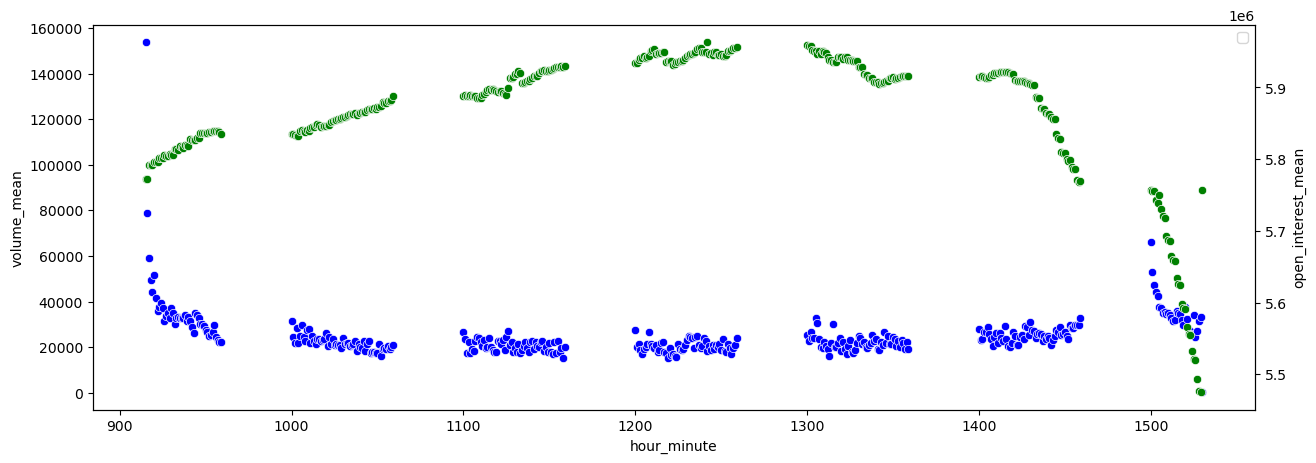

In [84]:
# plt.figure(figsize=(20,10))

vol_by_time = final.loc[final[col_dict['date_col']]==final[col_dict['expiry_col']]].groupby('hour_minute')[[col_dict['volume_col'], 
                                            col_dict['oi_col']
                                           ]].describe()
vol_by_time.columns = ['_'.join(col) for col in vol_by_time.columns]
vol_by_time.reset_index(inplace=True)
fig,ax1 = plt.subplots(figsize=(15, 5))
sns.scatterplot(vol_by_time, x = 'hour_minute', y = f"{col_dict['volume_col']}_mean", ax= ax1, color = 'b')
ax2 = ax1.twinx()
sns.scatterplot(vol_by_time, x = 'hour_minute', y = f"{col_dict['oi_col']}_mean", ax=ax2, color = 'g')
plt.legend()